# Dining Philosophers

For a description of the problem and a more documented code-walk through see https://www.kalasim.org/examples/dining_philosophers/

In [1]:
// %use krangl


In [14]:
%use kravis
// @file:DependsOn("com.github.holgerbrandl:kravis:0.7.1")

In [5]:
// @file:Repository("*mavenLocal")
@file:Repository("http://jcenter.bintray.com")
@file:DependsOn("com.github.holgerbrandl:kalasim:0.6.90")

In [6]:
import krangl.*

import org.kalasim.*

import org.kalasim.misc.repeat
import org.koin.core.component.get


## Entity Definition

In [7]:
// Define simulation types
class Fork : Resource()

class Philosopher(name: String, val leftFork: Fork, val rightFork: Fork) : Component(name) {
    val thinking = exponential(1)
    val eating = exponential(1)

    override fun process() = sequence {
        while(true) {
            hold(thinking())
            request(leftFork) {
                hold(0.1) // wait before taking the second fork
                request(rightFork) {
                    hold(eating())
                    log("$name is eating")
                }
            }
        }
    }
}

## Simulation

In [8]:
// run simulation
val sim = createSimulation {
    traceCollector()

    // create forks and resources
    val names = listOf("Socrates", "Pythagoras", "Plato", "Aristotle")
    val forks = repeat(names.size) { Fork() }
    names.forEachIndexed { idx, name ->
        Philosopher(name, forks[idx], forks[(idx + 1).rem(forks.size)])
    }

    run(100)
}

## Analysis

In [10]:
data class RequestRecord(val requester: String, val timestamp: Double, val resource: String, val quantity: Double)

val tc = sim.get<TraceCollector>()
val requests = tc.filterIsInstance<ResourceEvent>().map {
    val amountDirected = (if(it.type == ResourceEventType.RELEASED) -1 else 1) * it.amount
    RequestRecord(it.requester.name, it.time.value, it.resource.name, amountDirected)
}

val requestsDf = requests.asDataFrame()
    .groupBy("requester")
    .sortedBy("requester", "timestamp")
    .addColumn("end_time") { it["timestamp"].lead() }
    .filter { it["quantity"] gt 0 }
    .addColumn("state") { rowNumber.map { if(it.rem(2) == 0) "hungry" else "eating" } }
    .ungroup()

In [11]:
 requestsDf.schema()

Name,Type,Values,quantity,[Dbl],"1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",requester,[Str],"Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pyth...",resource,[Str],"Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork...",timestamp,[Dbl],"0.366, 0.466, 2.033, 5.903, 8.17, 11.108, 13.107, 14.125, 16.613, 17.834, 20.201, 21.242, 23.915, 26...",end_time,[Dbl],"0.466, 0.798, 5.903, 7.667, 11.108, 11.743, 14.125, 14.793, 17.834, 19.011, 21.242, 22.639, 26.769, ...",state,[Str],"eating, hungry, eating, hungry, eating, hungry, eating, hungry, eating, hungry, eating, hungry, eati..."


Inspect the table with resource request data

In [12]:
requestsDf.head(10)


quantity,requester,resource,timestamp,end_time,state
1.0,Pythagoras,Fork.2,0.36644694351969087,0.46644694351969085,eating
1.0,Pythagoras,Fork.3,0.46644694351969085,0.7975448471088381,hungry
1.0,Pythagoras,Fork.2,2.0333581882924627,5.903115284737927,eating
1.0,Pythagoras,Fork.3,5.903115284737927,7.667153147360637,hungry
1.0,Pythagoras,Fork.2,8.169713960895557,11.107736094590045,eating
1.0,Pythagoras,Fork.3,11.107736094590045,11.743329956261324,hungry


Let's try to visualize these data similar to https://r-simmer.org/articles/simmer-08-philosophers.html

In [15]:
import kravis.*


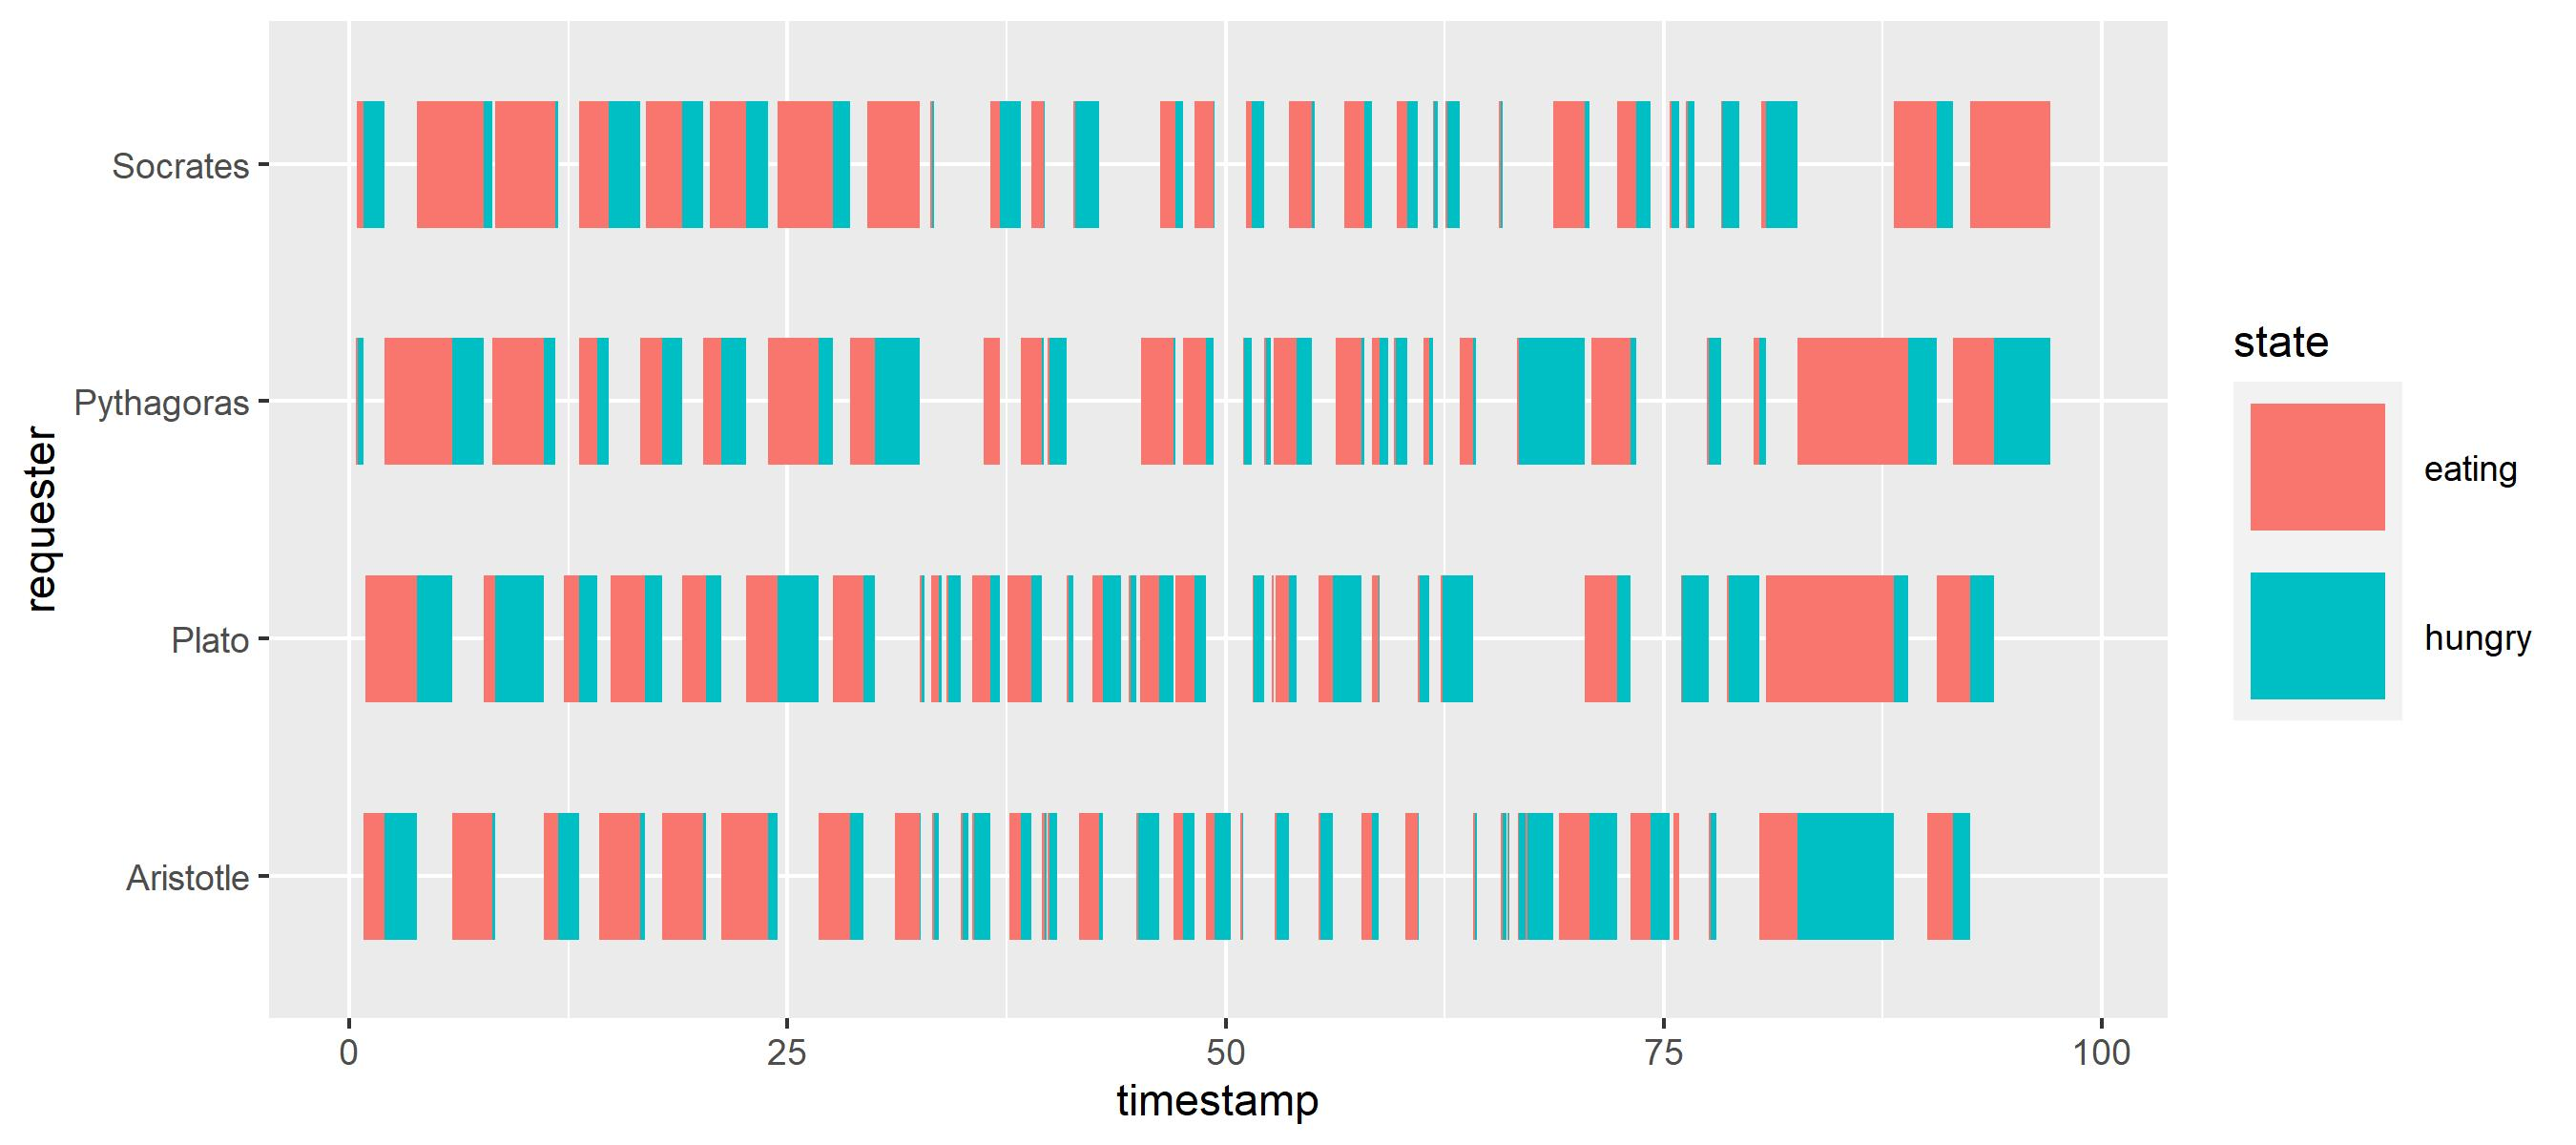

In [16]:
requestsDf.plot(x = "timestamp", xend = "end_time", y = "requester", yend = "requester", color = "state")
        .geomSegment(size = 15.0)

It is with great relief, that all 4 philosophers get a firm handle on 2 forks to enjory the tasty sphaghetti! 